## Tracking de Icebergs

In [21]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape, mapping
import json
import geemap,ee
import folium
ee.Authenticate()
ee.Initialize()

- Primero definimos nuestro icebergs de interes

Para este proceso, directamente en Google engine seleccionamos manualmente el icebreg de interes. Usando el siguiente codigo.

In [ ]:
# var roi = ee.Geometry.Polygon([
#   [[-112, -72.7], [-112, -73.7], [-108.5, -73.7], [-108.5, -72.7], [-112, -72.7]]
# ]);

# var startdate = '2017-04-19' 
# var enddate = '2017-04-20' 

# var S1 = sentinel1
#   // Filter to get images with VV and VH dual polarization.
#   //.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
#   // Filter to get images collected in interferometric wide swath mode.
#   .filterDate(startdate, enddate) 
#   // .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
#   .filterBounds(roi);
  
# print(S1)
# var img = S1.select("HH")

# var visParams1 = {band: ['HH'], min: -30, max: 0};
# // var visParams2 = {band: ['B4'], max: 10000, min: 0};

# Map.addLayer(img, visParams1, 'S1');

# Definimos "geometry" manualmente
# var geometry = ee.FeatureCollection(geometry)
# Export.table.toDrive(geometry, 'iceberg_' + startdate, 'users/kooala317/Iceberg_tracking')

In [195]:
df = pd.read_csv("Icebergs\iceberg_0001_2020-08-29.csv")
df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))

gdf = gpd.GeoDataFrame(df, geometry='geometry').set_crs('epsg:4326', inplace=True)

<Axes: >

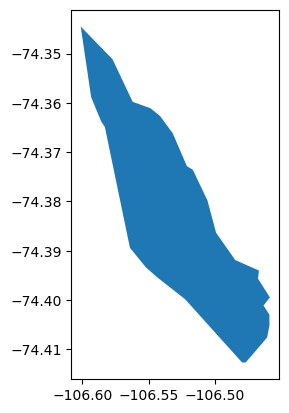

In [196]:
gdf["geometry"].plot()

- Luego, haciendo comparativas de similitud, localizamos el mismo iceberg en una imagen posterior. (Con un cierto margen de error)

#### 1. Pasamos nuestro archivo local a una Feature collection

In [197]:
gdf.columns = [col.replace('.', '_') for col in gdf.columns]

# Verificamos que todas las columnas son strings
for col in gdf.columns:
    if col != 'geometry':
        gdf[col] = gdf[col].astype(str)

# Convertimos el GeoDataFrame a una lista de Features
features = []
for _, row in gdf.iterrows():
    geom = ee.Geometry(mapping(row['geometry']))
    feature = ee.Feature(geom, row.drop('geometry').to_dict())
    features.append(feature)


iceberg = ee.FeatureCollection(features)


#### 2. Una vez obtenida la feature collection del iceberg, obtenemos las imagenes satelitales de esté.

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD

In [216]:
fecha_inicio = '2020-08-29'
fecha_fin = '2020-08-30'

In [217]:
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate(fecha_inicio, fecha_fin)\
.filterBounds(iceberg)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean().clip(iceberg) 

#### 3. Planteamos una forma de identificar el iceberg. Esta forma requiere calcular cómo varía la distancia desde el centroide hacia los bordes del iceberg. Para ello:

- Definimos una capa de cobertura del iceberg, la cual vale 1 siempre que se abarca el iceberg.

In [218]:
cover = img.select('HH').clip(iceberg).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())

- Definimos una Imagen que vale 1 en el centroide del Iceberg.

In [219]:
centroid = iceberg.geometry().centroid(10).getInfo()['coordinates']

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1)

- Calculamos el costo acumulativo para recorrer la imagen desde el centroide del iceberg hasta los bordes del iceberg.

In [220]:
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(iceberg)

result = cumulativeCost.reduceRegion(ee.Reducer.toList(), iceberg, scale=200, maxPixels=1e20)
A = result.getInfo()['cumulative_cost'] 

- Calculamos un histograma de la distribucion de las distancias centroide-borde

Text(0, 0.5, 'N')

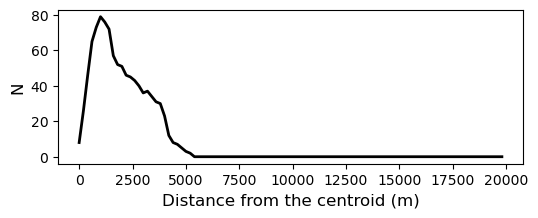

In [221]:
hist1 = {}

scale = 200
max_pix = 20000

fig = plt.subplots(figsize = (6, 2), dpi = 100)
hist1['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])

plt.plot(hist1['reference'][1][:-1], hist1['reference'][0], color = "k", linewidth = 2)
plt.xlabel("Distance from the centroid (m)", fontsize = 12)
plt.ylabel("N", fontsize = 12)

- Obtenemos el area real del iceberg

In [222]:
area0 = iceberg.geometry().area(10).getInfo()
print(area0)

10811089.37443775


In [ ]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
visParams1 = {"bands": ['HH'], "min": -30, "max": 0}
Map.addLayer(img, visParams1, 'S1')
Map

Map(center=[-74.3826133051304, -106.53108885292386], controls=(WidgetControl(options=['position', 'transparent…

4. Ahora queremos Trackear nuestro iceberg en un lapso de tiempo usando lo anterior.

En cada iteración segmentaremos la zona objetivo usando snic eh identificaremos el iceberg de estudio usando lo anterior.

In [ ]:
ice_area = {}
ice_centroid = {}
mapid_seg = {}
mapid_target = {}

startdate = fecha_inicio; enddate = fecha_fin
center = centroid

buf_dist = 25000 # distancia desde el centroide para buscar icebergs

# Map initialization (note: if you run this code, map is entirely initialized!)
map1 = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

Dias de estudio

In [ ]:
# Cuantos dias queremos estudiar
day_range = range(0, 6)

Calculo Area de cada iceberg

In [ ]:
#decidir si mantener o no el parametro maxError=10
def addArea(feature):
    return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)})

2020-05-01 ============================================
Feature 0 >>> area: 11.61 km^2, centroid: [-105.773, -74.417], similarity: 0.971
... exporting task for 2020-05-01


KeyboardInterrupt: 

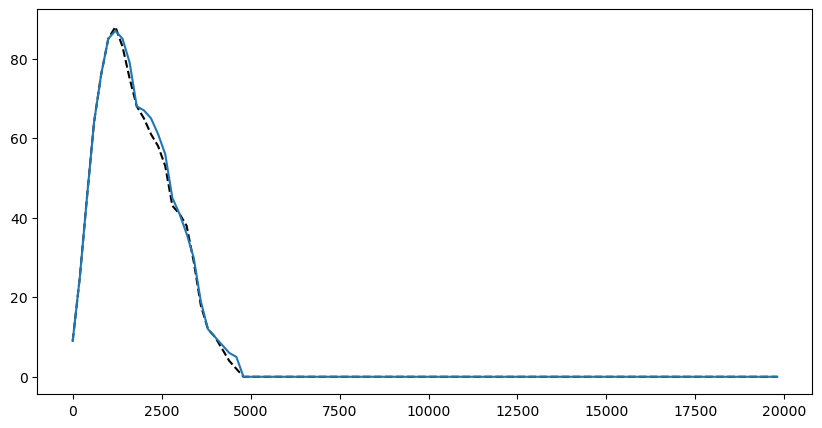

In [ ]:
vectorscale = 40

fig = plt.subplots(figsize = (10, 5))
plt.plot(hist1['reference'][1][:-1], hist1['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    aoi = ee.Geometry.Point(center).buffer(buf_dist)

    # Utilizamos las imagenes HH de Sentinel-1
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(aoi)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(aoi) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(80);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        
        
        # segmentamos la imagen con SNIC
        # size = 20, compactness= 5, connectivity= 8, neighborhoodSize = 256
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')       

        # dividimos los valores HH por los valores de la banda angle para mejorar el contraste entre los icebergs y el mar abierto o el hielo circundante.
        ratio = snic.select("HH").divide(snic.select("angle"))
        # mantenemos solo los valores mayores que -0.2 (icebergs)
        icebergs = ratio.gt(-0.2).selfMask()     
        
        # convertimos los iceberg raster a vectores
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        # permitimos un margen de error del 20% en el area de los icebergs respecto al iceberg objetivo
        area_max = area0 * 1.2
        area_min = area0 * 0.8
        # obtenemos el area y el centroide de los icebergs
        areaAdded = vectors.map(addArea)
        # filtramos los icebergs que tienen un area entre el 80% y el 120% del area objetivo
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.70
        
        for k in range(0, num):
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist1['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist1['reference'][0])          
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist1[startdate] = B 
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                  
                threshold = similarity
                
                def add_columns(feature):
                    return feature.set({"area": feature.geometry().area(10),
                                        "centroid": feature.geometry().centroid(10),
                                        "similarity": similarity,
                                        "refdate": '2017-05-01'});
                
                polygon2 = polygon.map(add_columns)
                
                task = ee.batch.Export.table.toDrive(
                    collection = polygon2,
                    folder = 'Iceberg_tracking_auto',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                # task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                ## Mapping images ==========================================
                # Original image -----------------------------------
                vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': aoi}
                mapid_seg[startdate] = img.getMapId(vis_seg)

                folium.TileLayer(
                  tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
                  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                  overlay=True,
                  name='S1_{0}'.format(startdate),
                ).add_to(map1)
                
                # Segmentation result -----------------------------------
                vis_seg = {'color': 'red'}
                seg_tile = segments.getMapId(vis_seg)

                folium.TileLayer(
                  tiles=seg_tile['tile_fetcher'].url_format,
                  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                  overlay=True,
                  name="seg_" + startdate,
                ).add_to(map1)
        
                vis_target = {'color': color_codes[month-1]}
                mapid_target = polygon.getMapId(vis_target) 

                # Map of iceberg vectors ---------------------------------
                folium.TileLayer(
                    tiles=mapid_target['tile_fetcher'].url_format,
                    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                    overlay=True,
                    name=startdate + "_" + str(k),
                ).add_to(map1) 
                ## ===========================================================
                
                center = centroid
                buf_dist = 0
            
            
    if (buf_dist > 250000) or (startdate == "2020-07-01"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=1)).strftime("%Y-%m-%d")

plt.legend()
map1.add_child(folium.LayerControl())
map1

In [ ]:
ice_area = {}
ice_centroid = {}
mapid_seg = {}
mapid_target = {}

In [36]:
ice_area

{'2020-05-01': 11613177.217557186,
 '2020-05-02': 11128562.119543703,
 '2020-05-03': 10686749.738468338,
 '2020-05-05': 11319674.827258816,
 '2020-05-06': 11162628.975842219}

In [224]:
df_iceberg = pd.DataFrame(columns=['fecha', 'similaridad', 'area', 'centroide', 'poligono', 'source', 'covers'])

2020-08-29 ============================================
Feature 0 >>> area: 12.41 km^2, centroid: [-106.533, -74.384], similarity: 0.852
Se aumento la distancia de busqueda a 35000
2020-09-02 ============================================
Feature 0 >>> area: 10.84 km^2, centroid: [-106.549, -74.39], similarity: 0.957
Se aumento la distancia de busqueda a 35000
Se aumento la distancia de busqueda a 45000
2020-09-10 ============================================
Feature 0 >>> area: 9.04 km^2, centroid: [-105.441, -74.633], similarity: 0.639
Feature 1 >>> area: 8.7 km^2, centroid: [-105.553, -74.661], similarity: 0.723
Feature 2 >>> area: 9.63 km^2, centroid: [-106.528, -74.326], similarity: 0.844
Feature 3 >>> area: 11.49 km^2, centroid: [-107.039, -74.306], similarity: 0.425
Feature 4 >>> area: 9.72 km^2, centroid: [-107.455, -74.203], similarity: 0.632
Feature 5 >>> area: 10.75 km^2, centroid: [-107.851, -74.549], similarity: 0.635
Se aumento la distancia de busqueda a 35000
2020-09-14 ===

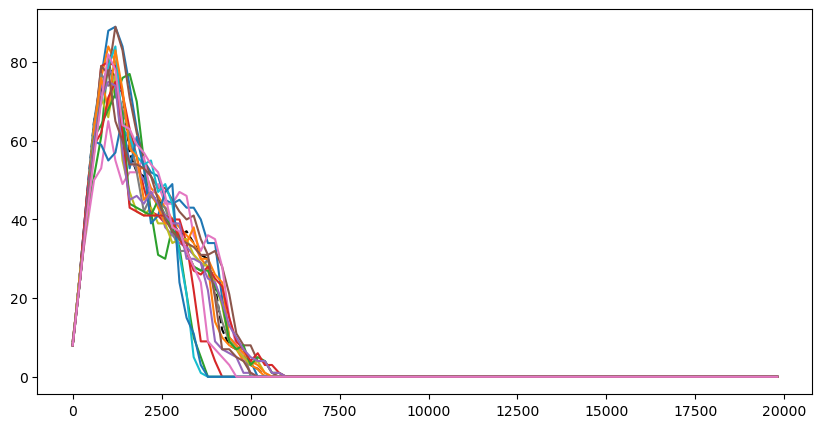

In [225]:
ice_area = {}
ice_centroid = {}
mapid_seg = {}
mapid_target = {}

startdate = fecha_inicio; enddate = fecha_fin
center = centroid

buf_dist = 25000 # buffer distance to find from the center to find icebergs

# Map initialization (note: if you run this code, map is entirely initialized!)
map1 = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 30) # for about year (2019-2018)

vectorscale = 40

fig = plt.subplots(figsize = (10, 5))
plt.plot(hist1['reference'][1][:-1], hist1['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(80);
        
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')       

        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).selfMask()     
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = area0 * 1.2
        area_min = area0 * 0.8
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.7
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)

            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist1['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist1['reference'][0])          
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold: 

                df_iceberg.loc[len(df_iceberg.index)] = [startdate, similarity, area, centroid, polygon, sources, covers]

                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist1[startdate] = B 
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                  
                threshold = similarity
                
                center = centroid
                buf_dist = 25000
            
            
            
    if (buf_dist > 250000) or (startdate == "2020-07-01"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 10000 # add 25 km buffer for everyday searching process
    if buf_dist >= 35000:
        print(f'Se aumento la distancia de busqueda a {buf_dist}')
    startdate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=3)).strftime("%Y-%m-%d")
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=4)).strftime("%Y-%m-%d")

In [226]:
df_iceberg

,fecha,similaridad,area,centroide,poligono,source,covers
0,2020-08-29,0.852036,1.241343e+07,"[-106.53304465102542, -74.38402534369158]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,2020-09-02,0.957299,1.084332e+07,"[-106.54851754571136, -74.3895035628275]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,2020-09-10,0.722939,8.701004e+06,"[-105.5533849012749, -74.6611759199871]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,2020-09-10,0.844091,9.634485e+06,"[-106.52772152473743, -74.32565449562895]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,2020-09-14,0.916584,1.019169e+07,"[-106.74007728539537, -74.07754381034971]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
5,2020-09-26,0.833168,1.280681e+07,"[-107.4669973486122, -73.71721579015549]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
6,2020-10-04,0.812314,1.051108e+07,"[-106.82645310110324, -73.48802452493209]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
7,2020-10-04,0.929494,1.075146e+07,"[-107.5373261612001, -73.6738313453528]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
8,2020-10-08,0.889772,1.035975e+07,"[-107.49473605691601, -73.65554508296285]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
9,2020-10-20,0.771599,9.641647e+06,"[-107.14339522119039, -73.61349831071006]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [227]:

S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate(fecha_inicio, fecha_fin)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean()

In [228]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
Map.addLayer(img, vis_seg, 'sat')

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_iceberg.iterrows():
    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'cent-ice{i}')

Map.addLayerControl()
Map

Map(center=[-72.84669840132555, -108.75815196316574], controls=(WidgetControl(options=['position', 'transparen…

In [155]:
img = df_iceberg.iloc[20].source

In [229]:

S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2020-12-19', '2020-12-20')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean()

In [230]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
Map.addLayer(img, vis_seg, 'sat')

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_iceberg.iterrows():
    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'cent-ice{i}')

Map.addLayerControl()
Map

Map(center=[-72.84669840132555, -108.75815196316574], controls=(WidgetControl(options=['position', 'transparen…

In [211]:
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2020-09-14', '2020-09-15')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean()

In [212]:
df_acotado = df_iceberg.tail()

In [213]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
Map.addLayer(img, vis_seg, 'sat')

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_acotado.iterrows():
    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'cent-ice{i}')

Map.addLayerControl()
Map

Map(center=[-74.46145216359426, -107.1577137150064], controls=(WidgetControl(options=['position', 'transparent…

In [56]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
Map.addLayer(img, vis_seg, 'sat')

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_iceberg.iterrows():
    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'cent-ice{i}')

Map.addLayerControl()
Map

Map(center=[-74.20871632959688, -107.22544474857695], controls=(WidgetControl(options=['position', 'transparen…

In [59]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
Map.addLayer(img, vis_seg, 'sat')

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_iceberg.iterrows():
    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'cent-ice{i}')

Map.addLayerControl()
Map

Map(center=[-74.36387139785128, -105.96976232645038], controls=(WidgetControl(options=['position', 'transparen…

In [77]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
Map.addLayer(img, vis_seg, 'sat')

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_iceberg.iterrows():
    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'cent-ice{i}')

Map.addLayerControl()
Map

Map(center=[-74.43723465049283, -108.03988139483371], controls=(WidgetControl(options=['position', 'transparen…

In [100]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
Map.addLayer(img, vis_seg, 'sat')

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_iceberg.iterrows():
    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'cent-ice{i}')

Map.addLayerControl()
Map

Map(center=[-74.36415510232911, -105.95572341682997], controls=(WidgetControl(options=['position', 'transparen…

In [138]:
coords1 = df_iceberg.iloc[5]['centroide']
coords2 = df_iceberg.iloc[6]['centroide']

In [139]:
import math
def calcular_distancia(lat1, lon1, lat2, lon2):
    # Convertir grados a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Radio de la Tierra en metros
    R = 6371000
    
    # Diferencias de coordenadas
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    # Fórmula de Haversine
    a = math.sin(delta_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Distancia
    distancia = R * c
    
    return distancia

In [140]:
latitud1 = coords1[0]  # Madrid
longitud1 = coords1[1]  # Madrid
latitud2 = coords2[0]  # Barcelona
longitud2 = coords2[1] # Barcelona

distancia_metros = calcular_distancia(latitud1, longitud1, latitud2, longitud2)
print(f"La distancia entre Madrid y Barcelona es de {distancia_metros:.2f} metros.")

La distancia entre Madrid y Barcelona es de 19889.83 metros.
